# Unfairness in Adversarial Training

One of the key observations of the paper is that adversarial training creates unfair outcomes. Namely, the authors observe that although adversarial training increases robustness to adversarial attacks, it does to an unequal degree across classes. They note that:

1. The classes which are "harder" to learn (i.e. that have a higher standard error in the naturally trained model) tend to be less robust after adversarial training than classes which are "easier" to learn. 

2. The performance dip that accompanies adversarial training is worse for classes that are harder to learn.

Essentially, the model gets better at predicting what it was already good at, and worse at what it was bad at. It is this unfairness that is the focus of this work. 

In this notebook, we will train a fairly simple model on the Fashion MNIST dataset, then adversarially train the same architecture to see if we can identify this unfairness. 

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torch import unsqueeze

!pip install torchattacks
import torchattacks


In [ ]:
## If Running in google colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This will be the path-- assuming the Fair_Robust_Modeling directory sits in the home of your drive. 
# If not this command fails, locate the directory's location and set it appropriately in the cell below
# You should see 
! ls /content/drive/MyDrive/Fair_Robust_Modeling/

fashion_mnist_model_training.ipynb  model_artifacts
FRL_Remargin_fashion_MNIST.ipynb    utility_functions.py
FRL_Reweight_fashion_MNIST.ipynb


In [ ]:
dir_path = '/content/drive/MyDrive/Fair_Robust_Modeling/'

In [ ]:
# need to copy the utility functions to your colab root to import files. 
# Everything in front of "/utility_functions.py" should be your directory path above
!cp /content/drive/MyDrive/Fair_Robust_Modeling/utility_functions.py .

In [ ]:
from utility_functions import LeNet5, train_model, test_model, get_accs, show_both_losses_by_class

## Load Data / Explore Data -- Fashion MNIST


In [ ]:
# Image preprocessing modules
transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])

In [ ]:
# Download data 
train_data = datasets.FashionMNIST(root = '.',
                              train = True,
                              download = True, 
                              transform=transform)
test_data = datasets.FashionMNIST(root = '.',
                             train = False, 
                             download = True, 
                             transform=transform)


In [ ]:
# Define label names for displaying a sample of images
label_names = {0: 'T-shirt',
               1:'Trouser',
               2:'Pullover',
               3:'Dress',
               4:'Coat',
               5:'Sandal',
               6:'Shirt',
               7:'Sneaker',
               8:'Bag',
               9:'Ankle boot'}

This is a Bag:


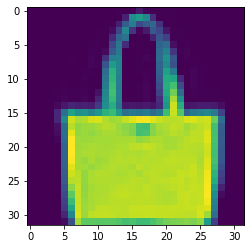

This is a Trouser:


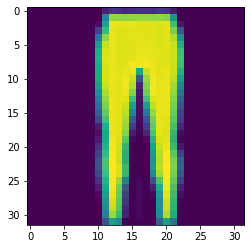

This is a Coat:


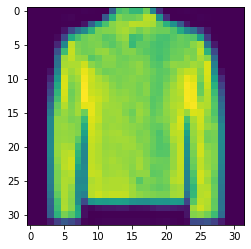

This is a T-shirt:


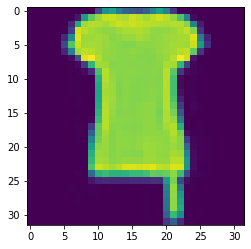

This is a Trouser:


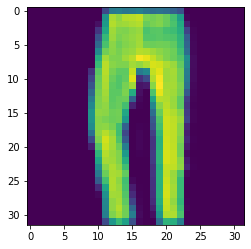

In [ ]:
# Preview a sample of the images
def display_images(n, data, random = True):
    if random:
        indices = np.random.choice(train_data.data.shape[0], size=n)
    else:
        indices = np.arange(n)
    for i in indices:
        image, label = train_data.__getitem__(i)
        if label ==9:
            print('This is an {}:'.format(label_names[label]))
        else:
            print('This is a {}:'.format(label_names[label]))
        plt.figure()
        plt.imshow(image[0])
        plt.show()

display_images(5, train_data)

In [ ]:
# Examine data shape
print('Training data shape: {}'.format(train_data.data.shape))
print('Testing data shape: {}'.format(test_data.data.shape))
# Our expectation is that the training set is 60,000 training samples
# and the test set is 10,000 testing samples

Training data shape: torch.Size([60000, 28, 28])
Testing data shape: torch.Size([10000, 28, 28])


## Naturally Train Model


In [ ]:
# Create dara loader instances for model training
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=100, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=100, 
                                          shuffle=False)

# Define model
natural_model = LeNet5(10)

# Hyper-parameters
num_epochs = 15
learning_rate = 0.001

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(natural_model.parameters(), lr=learning_rate)

# Call training process
natural_model = train_model(natural_model, num_epochs, learning_rate, device, criterion, optimizer, train_loader)

# Ensure model has reasonable performance
test_model(natural_model, device, test_loader, criterion)



Epoch [1/15], Step [100/600] Loss: 0.7280
Epoch [1/15], Step [200/600] Loss: 0.6218
Epoch [1/15], Step [300/600] Loss: 0.4756
Epoch [1/15], Step [400/600] Loss: 0.4557
Epoch [1/15], Step [500/600] Loss: 0.3581
Epoch [1/15], Step [600/600] Loss: 0.5073
Epoch [2/15], Step [100/600] Loss: 0.5155
Epoch [2/15], Step [200/600] Loss: 0.4056
Epoch [2/15], Step [300/600] Loss: 0.5817
Epoch [2/15], Step [400/600] Loss: 0.2929
Epoch [2/15], Step [500/600] Loss: 0.3219
Epoch [2/15], Step [600/600] Loss: 0.4010
Epoch [3/15], Step [100/600] Loss: 0.2766
Epoch [3/15], Step [200/600] Loss: 0.3306
Epoch [3/15], Step [300/600] Loss: 0.4794
Epoch [3/15], Step [400/600] Loss: 0.4939
Epoch [3/15], Step [500/600] Loss: 0.4055
Epoch [3/15], Step [600/600] Loss: 0.2562
Epoch [4/15], Step [100/600] Loss: 0.2627
Epoch [4/15], Step [200/600] Loss: 0.3833
Epoch [4/15], Step [300/600] Loss: 0.4118
Epoch [4/15], Step [400/600] Loss: 0.4623
Epoch [4/15], Step [500/600] Loss: 0.3030
Epoch [4/15], Step [600/600] Loss:

In [ ]:
torch.save(natural_model.state_dict(), dir_path+'model_artifacts/naturally_trained_model.pt')

In [ ]:
# OPTIONAL -- Load state dict and confirm model accuracy

natural_model_state = torch.load(dir_path+'model_artifacts/naturally_trained_model.pt')
natural_model = LeNet5(10)
natural_model.load_state_dict(natural_model_state)
natural_model.to(device)
test_model(natural_model, device, test_loader, criterion)


Test set: Average loss: 0.0032, Accuracy: 8844/10000 (88%)



## Adversarially Train Model

- First, we will test out torchattack's PGD on our naturally trained model to make sure we will fool it

- Then we will adversarially train a model using this attack

#### Demonstrate PGD

Raw Image


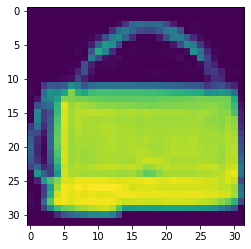

Adversarial Image


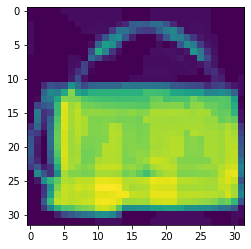

Label: 8
Base Guess: 8
Adversarial Guess: 8
----------------------------------------
Raw Image


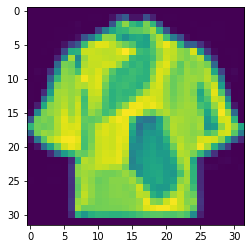

Adversarial Image


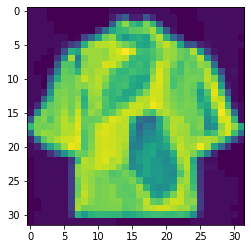

Label: 6
Base Guess: 8
Adversarial Guess: 8
----------------------------------------
Raw Image


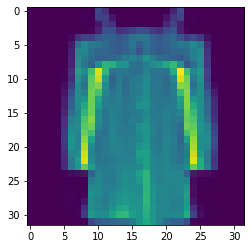

Adversarial Image


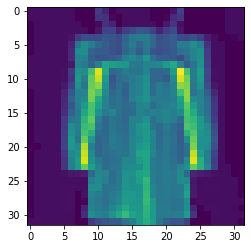

Label: 3
Base Guess: 3
Adversarial Guess: 6
----------------------------------------
Raw Image


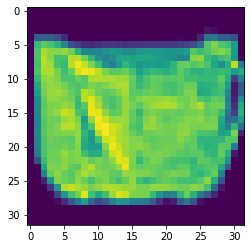

Adversarial Image


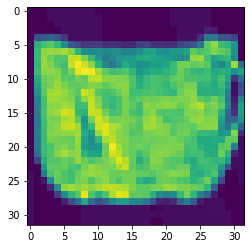

Label: 8
Base Guess: 8
Adversarial Guess: 8
----------------------------------------
Raw Image


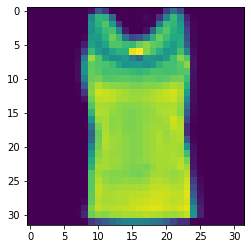

Adversarial Image


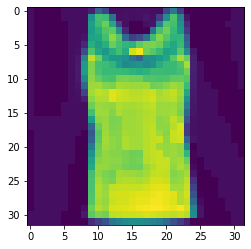

Label: 0
Base Guess: 0
Adversarial Guess: 3
----------------------------------------
Raw Image


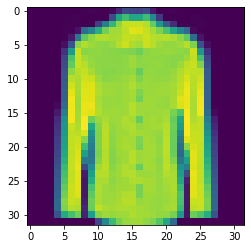

Adversarial Image


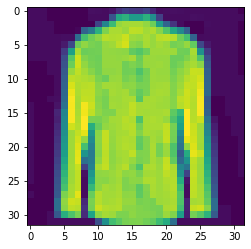

Label: 6
Base Guess: 6
Adversarial Guess: 2
----------------------------------------
Raw Image


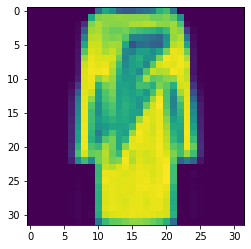

Adversarial Image


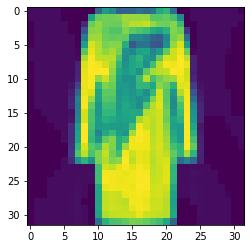

Label: 3
Base Guess: 3
Adversarial Guess: 3
----------------------------------------
Raw Image


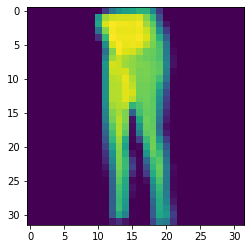

Adversarial Image


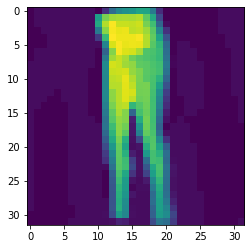

Label: 1
Base Guess: 1
Adversarial Guess: 1
----------------------------------------
Raw Image


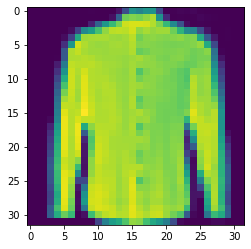

Adversarial Image


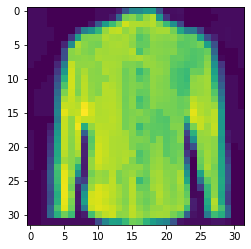

Label: 6
Base Guess: 6
Adversarial Guess: 4
----------------------------------------
Raw Image


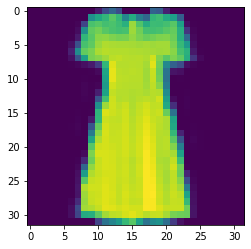

Adversarial Image


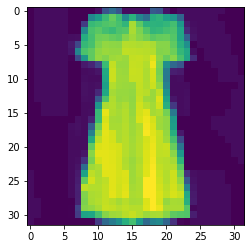

Label: 3
Base Guess: 3
Adversarial Guess: 3
----------------------------------------
Number wrong: 4
Percent wrong: 0.4


In [ ]:
## TEST PGD W CIFAR 10
batch_size = 10
train_loader_for_attack = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size, 
                                           shuffle=True)
show_results = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i, (raw_images, labels) in enumerate(train_loader_for_attack):
    if i > 0:
      break
    num_wrong = 0
    for j in range(raw_images.shape[0]):
        raw_image = raw_images[j, ::]
        label = labels[j]

        attacker = torchattacks.PGD(natural_model, eps=8/255, alpha=2/255, steps=20, random_start=True)
        adv_image = attacker(unsqueeze(raw_image, 0).to(device), unsqueeze(label, 0).to(device))

        model_guess = natural_model(unsqueeze(raw_image, 0).to(device)).max(1, keepdim=True)[1].item()
        adv_guess = natural_model(adv_image).max(1, keepdim=True)[1].item()

        if (show_results):
            print('Raw Image')
            plt.imshow(raw_image[0])
            plt.show()
            print('Adversarial Image')
            plt.imshow(adv_image[0,::][0].cpu())
            plt.show()

            print('Label: {}'.format(label))
            print('Base Guess: {}'.format(model_guess))
            print('Adversarial Guess: {}'.format(adv_guess))

            print('----------------------------------------')

        if model_guess != adv_guess:
            num_wrong+=1


    print('Number wrong: {}'.format(num_wrong))
    print('Percent wrong: {}'.format(num_wrong/batch_size))

#### Adversarially Train Model


In [ ]:
%%time
# Create dara loader instances for model training
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=100, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=100, 
                                          shuffle=False)

# Hyper-parameters
num_epochs = 15
learning_rate = 0.001

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
adv_model = LeNet5(10).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(adv_model.parameters(), lr=learning_rate)

# Define attack
eps=8/255
alpha=2/255
steps=20
atk = torchattacks.PGD(adv_model, eps=eps, alpha=alpha, steps=steps, random_start=True)

# Adversarially Train Model
adv_model = train_model(adv_model, 
                        num_epochs, 
                        learning_rate, 
                        device, 
                        criterion, 
                        optimizer, 
                        train_loader, 
                        adv=True, 
                        atk=atk)

# Test model accuracy
test_model(adv_model, device, test_loader, criterion)


Epoch [1/15], Step [100/600] Loss: 0.8043
Epoch [1/15], Step [200/600] Loss: 0.6973
Epoch [1/15], Step [300/600] Loss: 0.6195
Epoch [1/15], Step [400/600] Loss: 0.5924
Epoch [1/15], Step [500/600] Loss: 0.6904
Epoch [1/15], Step [600/600] Loss: 0.7393
Epoch [2/15], Step [100/600] Loss: 0.6655
Epoch [2/15], Step [200/600] Loss: 0.6492
Epoch [2/15], Step [300/600] Loss: 0.5436
Epoch [2/15], Step [400/600] Loss: 0.6026
Epoch [2/15], Step [500/600] Loss: 0.4748
Epoch [2/15], Step [600/600] Loss: 0.5129
Epoch [3/15], Step [100/600] Loss: 0.5974
Epoch [3/15], Step [200/600] Loss: 0.4331
Epoch [3/15], Step [300/600] Loss: 0.4462
Epoch [3/15], Step [400/600] Loss: 0.4430
Epoch [3/15], Step [500/600] Loss: 0.5431
Epoch [3/15], Step [600/600] Loss: 0.5141
Epoch [4/15], Step [100/600] Loss: 0.4675
Epoch [4/15], Step [200/600] Loss: 0.7494
Epoch [4/15], Step [300/600] Loss: 0.5046
Epoch [4/15], Step [400/600] Loss: 0.6434
Epoch [4/15], Step [500/600] Loss: 0.6040
Epoch [4/15], Step [600/600] Loss:

In [ ]:
torch.save(adv_model.state_dict(), dir_path+'model_artifacts/adversarially_trained_model.pt')

## Compare Natural/PGD Accuracy -- Fashion MNIST


In [ ]:
adv_model_state = torch.load(dir_path+'model_artifacts/adversarially_trained_model.pt')
adv_model = LeNet5(10)
adv_model.load_state_dict(adv_model_state)

natural_model_state = torch.load(dir_path+'model_artifacts/naturally_trained_model.pt')
natural_model = LeNet5(10)
natural_model.load_state_dict(natural_model_state)


<All keys matched successfully>

In [ ]:
test_loader = test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=300, 
                                          shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

natural_model.to(device)
adv_model.to(device)

eps= 16/255
alpha=2/255
steps=20

natural_model_pgd_loss = get_accs(natural_model, test_loader, criterion, device, eps, alpha, steps, adv=True)
natural_model_regular_loss = get_accs(natural_model, test_loader, criterion, device, eps, alpha, steps, adv=False)

adv_model_pgd_loss = get_accs(adv_model, test_loader, criterion, device, eps, alpha, steps, adv=True)
adv_model_regular_loss = get_accs(adv_model, test_loader, criterion, device, eps, alpha, steps, adv=False)

Working on round 1
Working on round 2
Working on round 3
Working on round 4
Working on round 5
Working on round 6
Working on round 7
Working on round 8
Working on round 9
Working on round 10
Working on round 11
Working on round 1
Working on round 2
Working on round 3
Working on round 4
Working on round 5
Working on round 6
Working on round 7
Working on round 8
Working on round 9
Working on round 10
Working on round 11
Working on round 1
Working on round 2
Working on round 3
Working on round 4
Working on round 5
Working on round 6
Working on round 7
Working on round 8
Working on round 9
Working on round 10
Working on round 11
Working on round 1
Working on round 2
Working on round 3
Working on round 4
Working on round 5
Working on round 6
Working on round 7
Working on round 8
Working on round 9
Working on round 10
Working on round 11


Regularly Trained Fashion MNIST Model-- ACCURACY


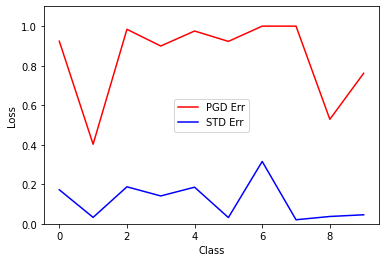

In [ ]:
print('Regularly Trained Fashion MNIST Model-- ACCURACY')
show_both_losses_by_class(natural_model_pgd_loss, natural_model_regular_loss, acc=True)


Adversarially Trained Fashion MNIST Model-- ACCURACY


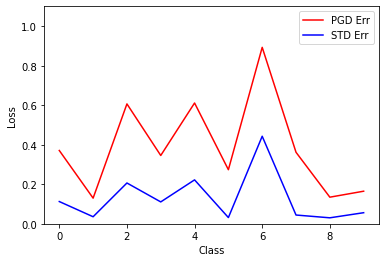

In [ ]:
print('Adversarially Trained Fashion MNIST Model-- ACCURACY')
show_both_losses_by_class(adv_model_pgd_loss, adv_model_regular_loss, acc=True)

## Conclusions

As we can see above, the naturally trained model has low standard error, but high PGD error. The adversarially trained model, in contrast, has a much lower PGD error, but higher standard error. In particular, we can observe that the 